# III. SVM classification 4


### Goals

* AS  III. SVM_Sentencetraining3 but focus on M&A only
* Adapted to work with latest version of spacy (03/20)

### Comments



## Lexical features

* token n-gram features: unigrams,bigrams, trigrams
* character n-gram fatures: trigrams,fourgrams
* lemma n-gram features: uni,bi,trigrams
* disambiguated lemmas: Lemma + POS tag
* numerals: yes,no
* symbols: yes,no
* time indicators: yes, not
* future: add semantic knowledge from structured resources:
    * takeover=acquire, acquisition,
    * are word embedding sufficient to capture semantic knowledge?

## Syntactic features
* PoS categories: 
    * for each binary (yes,no)
    * 0,1,more; 
    * total number of occurances
* named entity types: person, organization, location, product, event, 


    NE Type 	Examples
    ORGANIZATION 	Georgia-Pacific Corp., WHO
    PERSON 	Eddy Bonte, President Obama
    LOCATION 	Murray River, Mount Everest
    DATE 	June, 2008-06-29
    TIME 	two fifty a m, 1:30 p.m.
    MONEY 	175 million Canadian Dollars, GBP 10.40
    PERCENT 	twenty pct, 18.75 %
    FACILITY 	Washington Monument, Stonehenge
    GPE 	South East Asia, Midlothian

# Feature extraction on sentence level

In [111]:
import nltk,gensim, spacy

#nltk.data.path=[]
#nltk.data.path.append("C:\\Users\\rittchr\\nltk_data")
#nltk.data.path.append("\\esdfiles\INTERNAL\SpecialProjects\EconomicEventDetection\Analytics\nltk_data")

import re
import numpy as np
from collections import Counter
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC

from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import precision_recall_curve

In [2]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('tagsets')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')

In [3]:
#from nltk.data import load
#all_pos_tags = list(load('help/tagsets/upenn_tagset.pickle').keys())
#all_pos_tags

In [4]:
class extract_other_lexical_features(BaseEstimator, TransformerMixin):
    '''
    other lexical features such as time, special chars
    '''
    
    def fit(self, x, y=None):
        return self    

    def transform(self, sentences):
    
        def extract_other_lexical_features_int(sentence):
            '''
            Simple indicator variables if digits, symobls or times are mentioned in the sentence
            '''
        
            tokentext = nltk.word_tokenize(sentence)

            ## Check if it is digit, could also use POS tag 'NUM'
            digits = np.any([token.isdigit() for token in tokentext])
            #digits = [any(char.isdigit() for char in token) for token in tokentext] #any char contains digit

            ## contains symbols (true), other characters
            symbols = np.any([not token.isalnum() for token in tokentext])

            ## contains time indicators ('yesterday','today')
            time_indicator_list = ['yesterday','today','tomorrow']
            
            # note that I have already TIME as a NER tag below. However here I follow the paper.
            times = np.any([True if token in time_indicator_list else False for token in tokentext])
            
            return [digits,symbols,times] #{'digits':digits,'symbols':symbols,'times':times}
        
        return np.array([extract_other_lexical_features_int(sentence) for sentence in sentences])

In [5]:
#NER_types = ['ORGANIZATION','PERSON','LOCATION','DATE','TIME','MONEY','PERCENT','FACILITY','FACILITY']
NER_TYPES_spacy_all = ['PERSON','NORP','FAC','ORG','GPE','LOC','PRODUCT','EVENT','WORK_OF_ART','LAW','LANGUAGE','DATE','TIME','PERCENT','MONEY','QUANTITY','ORDINAL','CARDINAL']
#NER_TYPES_spacy_subset = ['ORG','PERSON','LOC','GPE','DATE','TIME','MONEY','PERCENT']

In [6]:
 # load spacy's English language models
#en_nlp = spacy.load('en')
en_nlp = spacy.load('en_core_web_sm')

Tag map: https://github.com/explosion/spaCy/blob/master/spacy/lang/en/tag_map.py with meaning: https://www.clips.uantwerpen.be/pages/mbsp-tags

In [7]:
len(en_nlp.tokenizer.vocab.morphology.tag_map)

50

18 NER entities

https://spacy.io/api/annotation#named-entities

In [8]:
#! cat ~/opt/anaconda3/envs/py36/lib/python3.6/site-packages/spacy/lang/en/tag_map.py

In [9]:
from spacy.lang.en.tag_map import TAG_MAP
#TAG_MAP

In [32]:
# saved from previous first fit
UNIQUE_TAGS = ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
UNIQUE_NER = ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']

In [33]:
class extract_syntactic_features(BaseEstimator, TransformerMixin):
    '''
    each sub-feature vector is of length all_pos_tags, fixed vector lengths!
    '''
    
    def fit(self, x, y=None):
        return self    

    def transform(self, sentences):
        '''
        PoS Tagging and NER of sentence
        '''
        global UNIQUE_NER, UNIQUE_TAGS
        tags_docs = []
        ner_docs = []
        for doc in en_nlp.pipe(sentences): #, disable=["tagger", "parser"]):
            
            # Do something with the doc here
            #print([(ent.text, ent.label_) for ent in doc.ents])
            
            tags = [token.pos_ for token in doc]
            tags_docs.append(tags)
            
            ents = [ent.label_ for ent in doc.ents]
            ner_docs.append(ents)

        unique_tags = UNIQUE_TAGS #list(set(x for l in tags_docs for x in l))
        unique_ner = UNIQUE_NER #list(set(x for l in ner_docs for x in l))
        
        print("unique tags: ",unique_tags)
        print('uniquener: ', unique_ner)
        
        docs_features = []
        for tags,ners in zip(tags_docs,ner_docs):
            
            tag_occurance = [apt in tags for apt in unique_tags]
            
            count_dict = Counter(tags)
            
            # number of occurances
            tag_counts = [count_dict[apt] if apt in count_dict.keys() else 0 for apt in unique_tags]
            
            # occurance, 0, 1 or more
            tag_three_classes = [2 if tc>1 else tc for tc in tag_counts]
        
            
            # named entity recognition: person, organization, location, product, event,
                    
            ners_feature = [1 if ner in ners else 0 for ner in unique_ner]
            
            sent_features = tag_occurance+tag_three_classes+tag_three_classes #{'tag_occurance':tag_occurance,'tag_three_classes':tag_three_classes,'ners':ners}
            docs_features.append(sent_features)
            
        return np.array(docs_features)

In [34]:
def tokenize_lemmatize(sentence):
    
    #tokentext = nltk.word_tokenize(sentence)
    return [token.lemma_ for token in en_nlp(sentence)]

def tokenize_lemma_pos(sentence):
    '''
    Combine token name and pos label
    '''
    
    tokens = []
    
    for token in en_nlp(sentence):
            tokens.append(token.lemma_+'_'+token.pos_)

    #tokentext = nltk.word_tokenize(sentence)
    return tokens #[en_nlp(token[0])[0].lemma_+token[1] for token in nltk.pos_tag(tokentext)]

In [35]:
class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        self.shape = X.shape
        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [36]:
#test_sentence = 'The New York Times posted about people running marathons'

### Combining feature extraction

In [98]:
pipeline = Pipeline([
    
   # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            
            # Pipeline for getting syntactic features
            ('syntactic_features', Pipeline([
                ('extract_syntactic_features', extract_syntactic_features()),
                ("debug", Debug()),

                #('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),    
    

            # Pipeline for getting other lexical features
            ('other_lexical_features', Pipeline([
                ('extract_other_lexical_features', extract_other_lexical_features()),
                #('vect', DictVectorizer()),  # list of dicts -> feature matrix
                ("debug", Debug()),

            ])),               
    
            # word token ngrams
            ('word_ngrams', Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,3),analyzer='word',min_df=5)),
                ("debug", Debug())
            ])),
    
    
            # character token ngrams
            ('char_ngrams', Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(3,4),analyzer='char')),
                ("debug", Debug())
            ])),     
    
            
    
            ## lemma n-gram features, MODIFIED tokenizer=tokenize_lemmatize,
            ('lemma_ngrams', Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,3),tokenizer=tokenize_lemmatize,analyzer='word',min_df=5)),
                ("debug", Debug())
            ])),              
    
            
            
            ## Get lemma + POS tags, MODIFIED, tokenizer=tokenize_lemma_pos,
            ('lemma_pos', Pipeline([
                ('tfidf', TfidfVectorizer(analyzer='word',tokenizer=tokenize_lemma_pos)),
                ("debug", Debug()),
            ]))     
            

        ]
        
        

        # weight components in FeatureUnion
        #transformer_weights={
        #    'subject': 1.0,
        #    'body_bow': 1.0,
        #    'body_stats': 1.0,
        #},
    )),
    
    ("debug_final", Debug()),

    # Use a SVC classifier on the combined features
    ('svc', LinearSVC(class_weight='balanced')),
    ])

In [99]:
path_corpus = './Data/jacobs_corpus.csv'

In [100]:
df=pd.read_csv(path_corpus)
df['sent_id'] = df.index

In [101]:
df.head(2)

,sentence,label,datatype,title,publication_date,file_id,-1,Profit,Dividend,MergerAcquisition,SalesVolume,BuyRating,QuarterlyResults,TargetPrice,ShareRepurchase,Turnover,Debt,sent_id
0,It will not say what it has spent on the proje...,-1,holdin,tesco,25-09-2013,833,1,0,0,0,0,0,0,0,0,0,0,0
1,"Sir John Bond , chairman , told the bank 's an...",-1,holdin,FT other HSBC,28-05-2005,393,1,0,0,0,0,0,0,0,0,0,0,1


In [102]:
df['datatype'].value_counts()

holdin     8943
holdout     994
Name: datatype, dtype: int64

In [103]:
multi_labels = ['-1',
       'Profit', 'Dividend', 'MergerAcquisition', 'SalesVolume', 'BuyRating',
       'QuarterlyResults', 'TargetPrice', 'ShareRepurchase', 'Turnover',
       'Debt']

In [104]:
one_label = 'MergerAcquisition'

In [105]:
X = df['sentence']
y = df[one_label]
X.shape,y.shape

((9937,), (9937,))

In [106]:
# random split
X_train, X_test, y_train, y_test,sent_id_train,sent_id_test = train_test_split(X, y, df['sent_id'],test_size=0.33, random_state=2018)

# split as in Jacobs18
X_train, X_test = X[df['datatype']=='holdin'], X[df['datatype']=='holdout']
y_train, y_test = y[df['datatype']=='holdin'], y[df['datatype']=='holdout']
sent_id_train, sent_id_test = df['sent_id'][df['datatype']=='holdin'], df['sent_id'][df['datatype']=='holdout']


In [107]:
X_train.shape,X_test.shape

((8943,), (994,))

In [108]:
%%time
pipeline.fit(X_train,y_train)

unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
CPU times: user 3min 45s, sys: 10.8 s, total: 3min 56s
Wall time: 4min 40s


/Users/christian/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('syntactic_features',
                                                 Pipeline(memory=None,
                                                          steps=[('extract_syntactic_features',
                                                                  extract_syntactic_features()),
                                                                 ('debug',
                                                                  Debug())],
                                                          verbose=False)),
                                                ('other_lexical_features',
                                                 Pipeline(memory=None,
                                                          steps=[('extract_other_lexical_features',
                                                                  extract_other_lexical_features()),


In [109]:
#pipeline.steps
#pipeline.get_params()['svc']

#### Feature dimensions

In [110]:
'syntactic_features: ',pipeline.get_params()['union'].get_params()['syntactic_features'].get_params()['debug'].shape, \
'other_lexical_features: ',pipeline.get_params()['union'].get_params()['other_lexical_features'].get_params()['debug'].shape, \
'word_ngrams: ',pipeline.get_params()['union'].get_params()['word_ngrams'].get_params()['debug'].shape,\
'char_ngrams: ',pipeline.get_params()['union'].get_params()['char_ngrams'].get_params()['debug'].shape,\
'lemma_ngrams: ',pipeline.get_params()['union'].get_params()['lemma_ngrams'].get_params()['debug'].shape, \
'lemma_pos: ',pipeline.get_params()['union'].get_params()['lemma_pos'].get_params()['debug'].shape, \
'total dim: ',pipeline.get_params()['debug_final'].shape

('syntactic_features: ',
 (8943, 54),
 'other_lexical_features: ',
 (8943, 3),
 'word_ngrams: ',
 (8943, 10355),
 'char_ngrams: ',
 (8943, 47484),
 'lemma_ngrams: ',
 (8943, 12786),
 'lemma_pos: ',
 (8943, 12945),
 'total dim: ',
 (8943, 83627))

In [84]:
y_pred = pipeline.predict(X_test)

unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


### Evaluation

In [117]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [85]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       969
           1       0.50      0.28      0.36        25

    accuracy                           0.97       994
   macro avg       0.74      0.64      0.67       994
weighted avg       0.97      0.97      0.97       994



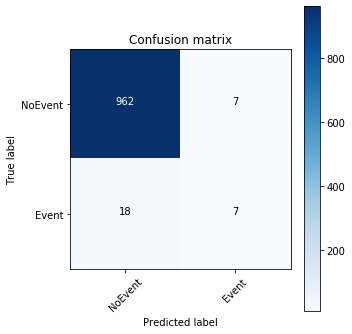

In [118]:
plot_confusion_matrix(confusion_matrix(y_test,y_pred),classes=['NoEvent','Event'])

### Evaluate results by looking at individual articles

In [91]:
y_decision = pipeline.decision_function(X_test)

unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


In [114]:
fpr, tpr, thresholds = roc_curve(y_test, y_decision)
precision, recall, thresholds = precision_recall_curve(y_test, y_decision)
roc_auc = auc(fpr, tpr)
roc_auc

0.9491847265221879

Text(0.5, 1.0, 'Precision-Recall Curve')

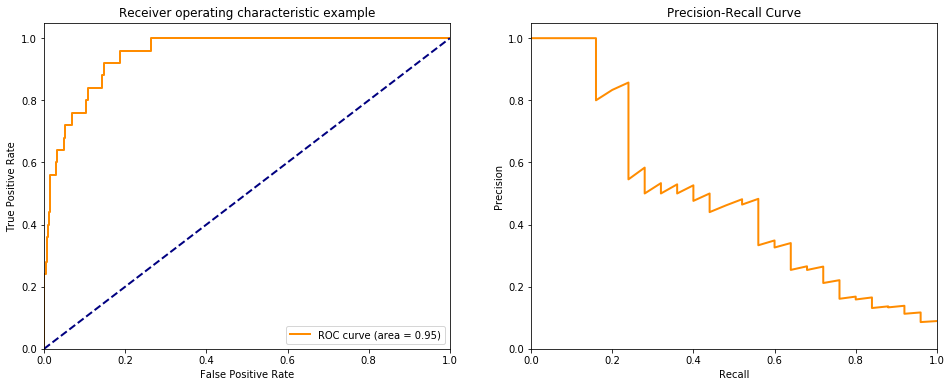

In [115]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

lw = 2
axs[0].plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver operating characteristic example')
axs[0].legend(loc="lower right")

axs[1].plot(recall, precision, color='darkorange',
         lw=lw)
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')

## Write out results

In [107]:
#from sklearn.externals import joblib
#joblib.dump(pipeline,'../Models/TrainingJacobs/model.joblib',compress=True)

### GridSearch

In [119]:
parameters = {'svc__C': [0.1, 1, 10, 100],'union__lemma_ngrams__tfidf__ngram_range':[(1,1),(1,2),(1,3)],
             'union__word_ngrams__tfidf__ngram_range':[(1,1),(1,2),(1,3)]}

In [120]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
%%time
grid = GridSearchCV(pipeline, param_grid=parameters, cv=2,verbose=10,scoring='f1') #cv=5
grid.fit(X_train,y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


/Users/christian/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 1), score=0.439, total= 4.3min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 1), score=0.425, total= 3.6min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.9min remaining:    0.0s


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


/Users/christian/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 2), score=0.427, total= 3.5min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.4min remaining:    0.0s


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


/Users/christian/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 2), score=0.419, total= 3.4min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 3) 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 14.8min remaining:    0.0s


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


/Users/christian/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 3), score=0.445, total= 3.5min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 3) 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.3min remaining:    0.0s


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 1), union__word_ngrams__tfidf__ngram_range=(1, 3), score=0.421, total= 3.9min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 22.1min remaining:    0.0s


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


/Users/christian/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 1), score=0.459, total= 3.4min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 25.6min remaining:    0.0s


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


/Users/christian/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 1), score=0.440, total= 3.5min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 29.1min remaining:    0.0s


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


/Users/christian/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 2), score=0.451, total= 3.9min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 33.0min remaining:    0.0s


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


/Users/christian/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 2), score=0.428, total= 3.8min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 3) 
unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


/Users/christian/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 3), score=0.451, total= 3.8min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 3) 
unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


/Users/christian/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']
[CV]  svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 2), union__word_ngrams__tfidf__ngram_range=(1, 3), score=0.432, total= 4.1min
[CV] svc__C=0.1, union__lemma_ngrams__tfidf__ngram_range=(1, 3), union__word_ngrams__tfidf__ngram_range=(1, 1) 
unique tags:  ['VERB', 'PUNCT', 'CCONJ', 'PROPN', 'SCONJ', 'ADV', 'NUM', 'INTJ', 'ADP', 'PART', 'PRON', 'ADJ', 'AUX', 'X', 'SPACE', 'DET', 'SYM', 'NOUN']
uniquener:  ['WORK_OF_ART', 'LOC', 'DATE', 'GPE', 'MONEY', 'FAC', 'PERSON', 'LAW', 'QUANTITY', 'PERCENT', 'ORDINAL', 'ORG', 'TIME', 'EVENT', 'PRODUCT', 'LANGUAGE', 'CARDINAL', 'NORP']


In [ ]:
grid.best_params_